# Overview

Step 1: Looking at ACF and PACF, choose the number of lag (p and q) from AR or MA model <br>
Step 2: fit the model <br>
Step 3: plot ACF for residual, is there still a pattern to look for? <br>
Step 4: incorperate any left over lag which can improve the model <br>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

# Read Data

In [2]:
raw=pd.read_csv('Data/Index2018.csv')
raw.head()

date     spx      dax     ftse    nikkei
0  07/01/1994  469.90  2224.95  3445.98  18124.01
1  10/01/1994  475.27  2225.00  3440.58  18443.44
2  11/01/1994  474.13  2228.10  3413.77  18485.25
3  12/01/1994  474.17  2182.06  3372.02  18793.88
4  13/01/1994  472.47  2142.37  3360.01  18577.26

In [3]:
raw.shape

(6269, 5)

# About Data

Terms

![Data Details](images/2024-01-23%2021_09_25-Greenshot.png)

Stock Price of : <br>
spx : USA's top 500 companies <br>
dax : Germany top 30 companies <br>
ftse : London top 100 companies <br>
nikkei : Japan 225 companies <br>

In [4]:
df=raw.copy()

In [5]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)
df.set_index(['date'],inplace=True)

In [6]:
df=df.asfreq('b')

## Missing Values

In [7]:
df.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [8]:
df.loc[df['spx'].isna()]

spx  dax  ftse  nikkei
date                              
2008-01-01  NaN  NaN   NaN     NaN
2009-01-01  NaN  NaN   NaN     NaN
2010-01-01  NaN  NaN   NaN     NaN
2013-01-01  NaN  NaN   NaN     NaN
2014-01-01  NaN  NaN   NaN     NaN
2015-01-01  NaN  NaN   NaN     NaN
2016-01-01  NaN  NaN   NaN     NaN
2018-01-01  NaN  NaN   NaN     NaN

In [9]:
df['day']=df.index.day_name()

In [10]:
df.iloc[0][['day']]=='Friday'

day    True
Name: 1994-01-07 00:00:00, dtype: bool

In [11]:
(df.iloc[0][['spx']].isna() & df.iloc[0][['day']]=='Friday')

day    False
spx    False
Name: 1994-01-07 00:00:00, dtype: bool

In [12]:
df.isna().iloc[0][['spx']]

spx    False
Name: 1994-01-07 00:00:00, dtype: bool

In [13]:
for i in range(df.shape[0]):
    if df.isna().iloc[i,0]:
        if df.iloc[i,-1]=='Friday':
            df.ffill(limit=1,inplace=True)
        elif df.iloc[i,-1]=='Monday':
            df.bfill(limit=1,inplace=True)

In [14]:
df.isnull().sum()

spx       0
dax       0
ftse      0
nikkei    0
day       0
dtype: int64

## Basic Plots

In [15]:
px.line(df,y=df.columns[0:4])

# Simplfying data : Only taking spx column

In [16]:
df.drop(columns=df.columns[1:],inplace=True)

In [17]:
df.rename({'spx':'market_value'},axis=1,inplace=True)

In [18]:
df.head()

market_value
date                    
1994-01-07        469.90
1994-01-10        475.27
1994-01-11        474.13
1994-01-12        474.17
1994-01-13        472.47

# White Noise

In [19]:
wn=np.random.normal(loc=df.market_value.mean(),scale=df.market_value.var(),size=df.shape[0])
df['wn']=wn

In [20]:
fig=px.line(df,y='wn',title='White Noise Time Series')
fig.update_layout(title={'font_size':24})


# Random Walk
Prive for today depends on yesterday + some error
$$
    P_t=P_{t-1}+E_t\space where\space E_t=N(\mu,\sigma^2)
$$

In [21]:
rw=pd.read_csv('Data/RandWalk.csv')
rw.head()

date        price
0  07/01/1994  1122.139662
1  08/01/1994  1135.238562
2  09/01/1994  1109.897831
3  10/01/1994  1080.347860
4  11/01/1994  1082.095245

In [22]:
rw['date']=pd.to_datetime(rw['date'],dayfirst=True)

In [23]:
rw.set_index(['date'],inplace=True)

In [24]:
rw.isnull().sum()

price    0
dtype: int64

In [25]:
rw.asfreq('b')

price
date                   
1994-01-07  1122.139662
1994-01-10  1080.347860
1994-01-11  1082.095245
1994-01-12  1083.639265
1994-01-13  1067.146255
...                 ...
2013-04-01  2263.675474
2013-04-02  2225.000870
2013-04-03  2190.787688
2013-04-04  2195.240033
2013-04-05  2152.992143

[5021 rows x 1 columns]

In [26]:
rw=rw.asfreq('b')

In [27]:
rw.isnull().sum()

price    0
dtype: int64

In [28]:
px.line(rw,y='price')

# Stationary

In [29]:
df.columns

Index(['market_value', 'wn'], dtype='object')

In [30]:
from statsmodels.tsa.stattools import adfuller
adfuller(df.market_value)

(1.1194986381728387,
 0.9953796476080692,
 10,
 6266,
 {'1%': -3.4313940441948807,
  '5%': -2.8620013751563964,
  '10%': -2.567015587023998},
 50258.209867750025)

In [31]:
adfuller(df.wn)

(-78.77140706241943,
 0.0,
 0,
 6276,
 {'1%': -3.4313923799633836,
  '5%': -2.862000639842268,
  '10%': -2.567015195598801},
 172443.0942243155)

In [32]:
adfuller(rw.price)

(-1.3286073927689719,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

# Seasonality
seasondal-decompose

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_add=seasonal_decompose(df['market_value'],model='additive')
decompose_add

In [34]:
import matplotlib.pyplot as plt

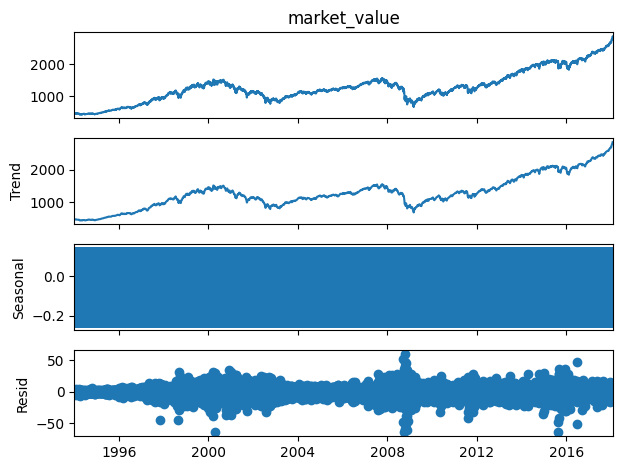

In [35]:
decompose_add.plot()
plt.show()

# ACF and PACF

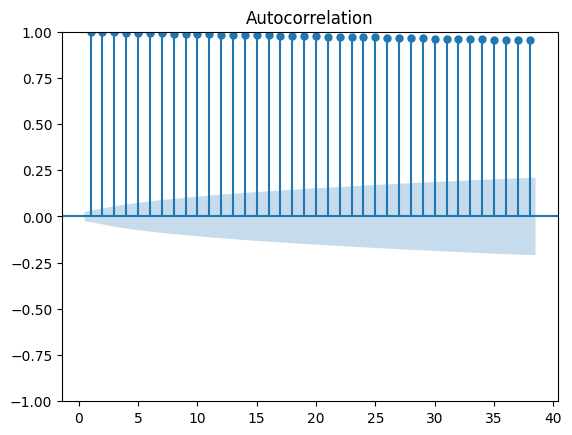

In [36]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(df['market_value'],zero=False)
plt.show()

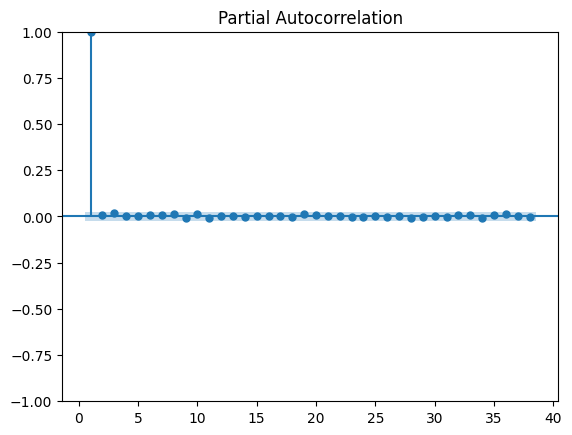

In [37]:
sgt.plot_pacf(df['market_value'],zero=False)
plt.show()

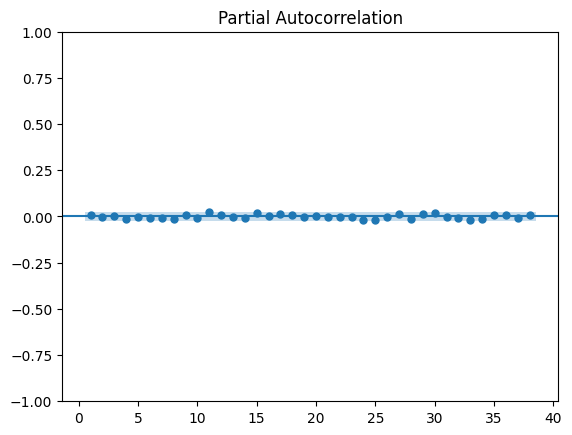

In [38]:
sgt.plot_pacf(df['wn'],method='ols',zero=False)
plt.show()

# Auto Regression

## Using Direct Ftse (not Return or difference)

### AR Models

In [39]:
data=raw.copy()
data['date']=pd.to_datetime(data['date'],dayfirst=True)
data.set_index(['date'],inplace=True)
data.drop(['spx', 'dax', 'nikkei'],inplace=True,axis=1)
data=data.asfreq('b').ffill()
size=int(len(data)*0.8)
df,df_test=data.iloc[:size],data.iloc[size:]

### The ACF

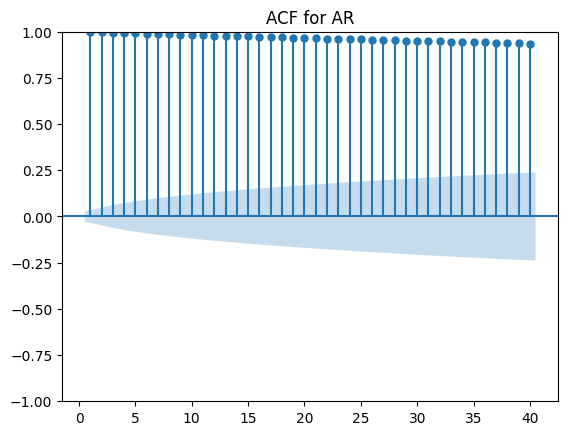

In [40]:
sgt.plot_acf(df.ftse,zero=False,title='ACF for AR',lags=40)
plt.show()

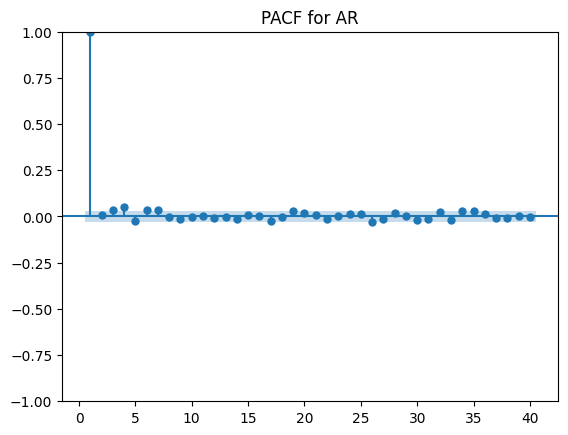

In [41]:
sgt.plot_pacf(df.ftse,zero=False,lags=40,title='PACF for AR')
plt.show()

In [42]:
# Stationary Check
adfuller(df.ftse)

(-1.904155141883686,
 0.3301089327702835,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

Not Stationary

In [43]:
# LLR test
from scipy.stats.distributions import chi2
def lr_test(model_1,model_2,df=1):
    ll1=model_1.fit().llf
    ll2=model_2.fit().llf
    lr=2*(ll1-ll2)
    p=chi2.sf(lr,df).round(3)
    return p

### AR(1)

In [44]:
df.shape

(5021, 1)

In [45]:
from statsmodels.tsa.arima.model import ARIMA

In [46]:
model_ar_1=ARIMA(df.ftse,order=(1,0,0))
result_ar_1=model_ar_1.fit()
result_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Thu, 01 Feb 2024   AIC                          55251.207
Time:                        11:30:55   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6374    423.329     12.023      0.000    4259.929    5919.346
ar.L1          0.9984      0.001   1147.578      0.000       0.997       1.000
sigma2      3511.3842     40.874     85.907      0.000    3431.272    3591.496
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              3313.33
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AR(2)

In [47]:
model_ar_2=ARIMA(df.ftse,order=(2,0,0))
result_ar_2=model_ar_2.fit()
result_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -27621.949
Date:                Thu, 01 Feb 2024   AIC                          55251.898
Time:                        11:30:56   BIC                          55277.984
Sample:                    01-07-1994   HQIC                         55261.039
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    368.251     13.821      0.000    4367.881    5811.400
ar.L1          0.9811      0.010     99.868      0.000       0.962       1.000
ar.L2          0.0171      0.010      1.749      0.080      -0.002       0.036
sigma2      3510.1277     41.037     85.535      0.000    3429.696    3590.560
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3282.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# LR Test AR(2) and AR(1)
lr_test(model_ar_2,model_ar_1)

0.253

### AR(3)

In [49]:
model_ar_3=ARIMA(df.ftse,order=(3,0,0))
result_ar_3=model_ar_3.fit()
result_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -27615.962
Date:                Thu, 01 Feb 2024   AIC                          55241.925
Time:                        11:30:59   BIC                          55274.532
Sample:                    01-07-1994   HQIC                         55253.351
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    378.583     13.444      0.000    4347.631    5831.651
ar.L1          0.9802      0.010     99.076      0.000       0.961       1.000
ar.L2         -0.0309      0.013     -2.315      0.021      -0.057      -0.005
ar.L3          0.0489      0.009      5.383      0.000       0.031       0.067
sigma2      3502.2643     41.020     85.379      0.000    3421.866    3582.662
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3286.97
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# LR Test AR(3) and AR(2)
lr_test(model_ar_3,model_ar_2)

0.001

### AR(7)

In [51]:
model_ar_7=ARIMA(df.ftse,order=(7,0,0))
result_ar_7=model_ar_7.fit()
result_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5021
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -27592.022
Date:                Thu, 01 Feb 2024   AIC                          55202.044
Time:                        11:31:02   BIC                          55260.736
Sample:                    01-07-1994   HQIC                         55222.610
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    405.380     12.555      0.000    4295.111    5884.171
ar.L1          0.9783      0.010     95.742      0.000       0.958       0.998
ar.L2         -0.0304      0.014     -2.183      0.029      -0.058      -0.003
ar.L3         -0.0267      0.013     -2.108      0.035      -0.052      -0.002
ar.L4          0.1039      0.013      8.053      0.000       0.079       0.129
ar.L5         -0.0668      0.012     -5.480      0.000      -0.091      -0.043
ar.L6         -0.0025      0.013     -0.199      0.842      -0.028       0.022
ar.L7          0.0427      0.010      4.397      0.000       0.024       0.062
sigma2      3471.0296     42.068     82.510      0.000    3388.578    3553.481
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3013.82
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AR(8)

In [52]:
model_ar_8=ARIMA(df.ftse,order=(8,0,0))
result_ar_8=model_ar_8.fit()
result_ar_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5021
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -27591.854
Date:                Thu, 01 Feb 2024   AIC                          55203.708
Time:                        11:31:04   BIC                          55268.922
Sample:                    01-07-1994   HQIC                         55226.560
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    407.243     12.498      0.000    4291.458    5887.823
ar.L1          0.9787      0.010     95.719      0.000       0.959       0.999
ar.L2         -0.0305      0.014     -2.183      0.029      -0.058      -0.003
ar.L3         -0.0273      0.013     -2.121      0.034      -0.053      -0.002
ar.L4          0.1047      0.013      7.984      0.000       0.079       0.130
ar.L5         -0.0670      0.012     -5.497      0.000      -0.091      -0.043
ar.L6         -0.0028      0.013     -0.216      0.829      -0.028       0.022
ar.L7          0.0505      0.014      3.598      0.000       0.023       0.078
ar.L8         -0.0080      0.010     -0.815      0.415      -0.027       0.011
sigma2      3471.3457     42.181     82.296      0.000    3388.672    3554.019
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3003.28
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
# LR test AR(1) and AR(7)
print('LR test p-value '+str(lr_test(model_ar_7,model_ar_1,df=6)))

LR test p-value 0.0


### Analysing the Residual

In [54]:
resid_ar_7=result_ar_7.resid
resid_ar_7.mean()

0.3519708988829107

In [55]:
resid_ar_7.var()

4005.822045824064

In [56]:
resid_ar_7

date
1994-01-07   -1643.660864
1994-01-10      -8.530196
1994-01-11     -29.989056
1994-01-12     -45.480241
1994-01-13     -17.493059
                 ...     
2013-04-01       1.419682
2013-04-02      83.398451
2013-04-03     -66.823950
2013-04-04     -71.051778
2013-04-05     -90.337756
Freq: B, Length: 5021, dtype: float64

In [57]:
resid_ar_7.iloc[0]=resid_ar_7.mean()

In [58]:
px.line(df,y=result_ar_7.resid,title='Residual of AR(7) over time')

In [59]:
# Check for stationarity
adfuller(resid_ar_7)

(-70.80589063366273,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 54842.15874022135)

## Using Returns
As ftse is not stationary, the Return could be stationary data

$$
    Return = \frac{p_{t}-p_{t-1}}{p_{t-1}}*100
$$

In [60]:
df['return']=df.ftse.pct_change(1).mul(100)
df=df.iloc[1:]

C:\Users\Linux\AppData\Local\Temp\ipykernel_10176\2808337934.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Checking Stationary

In [61]:
adfuller(df['return'])

(-12.770265719497244,
 7.798058336037938e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

Return are Stationary

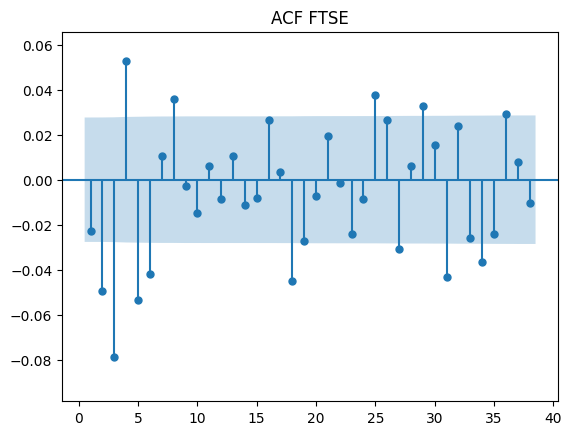

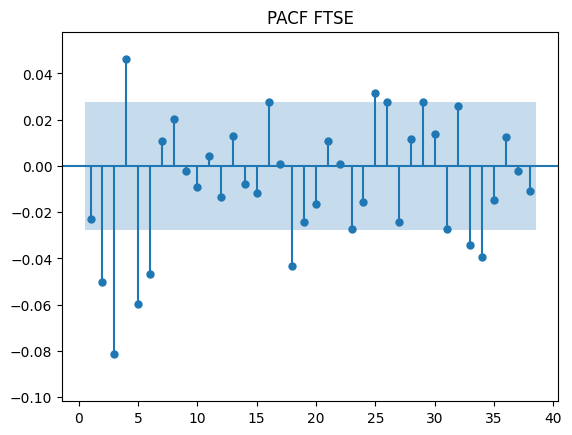

In [62]:
sgt.plot_acf(df['return'],zero=False,auto_ylims=True,title='ACF FTSE')
sgt.plot_pacf(df['return'],zero=False,auto_ylims=True,title='PACF FTSE')
plt.show()

## AR Models

### AR(1)

In [63]:
model_ret_ar_1=ARIMA(df['return'],order=(1,0,0))
result_ret_ar_1=model_ret_ar_1.fit()
result_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Thu, 01 Feb 2024   AIC                          15865.497
Time:                        11:31:09   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### High Lag Version

In [64]:
model_ret_ar_7=ARIMA(df['return'],order=(7,0,0))
result_ret_ar_7=model_ret_ar_7.fit()
result_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7886.647
Date:                Thu, 01 Feb 2024   AIC                          15791.294
Time:                        11:31:11   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.304      0.192      -0.010       0.047
ar.L1         -0.0240      0.009     -2.579      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.375      0.000      -0.068      -0.036
ar.L3         -0.0874      0.008    -10.725      0.000      -0.103      -0.071
ar.L4          0.0433      0.008      5.183      0.000       0.027       0.060
ar.L5         -0.0601      0.008     -7.463      0.000      -0.076      -0.044
ar.L6         -0.0463      0.009     -5.173      0.000      -0.064      -0.029
ar.L7          0.0109      0.009      1.205      0.228      -0.007       0.029
sigma2         1.3555      0.015     91.777      0.000       1.327       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6448.20
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
model_ret_ar_6=ARIMA(df['return'],order=(6,0,0))
result_ret_ar_6=model_ret_ar_6.fit()
result_ret_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7886.945
Date:                Thu, 01 Feb 2024   AIC                          15789.890
Time:                        11:31:13   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.324      0.186      -0.009       0.047
ar.L1         -0.0245      0.009     -2.640      0.008      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.505      0.000      -0.068      -0.037
ar.L3         -0.0870      0.008    -10.853      0.000      -0.103      -0.071
ar.L4          0.0424      0.008      5.133      0.000       0.026       0.059
ar.L5         -0.0607      0.008     -7.568      0.000      -0.076      -0.045
ar.L6         -0.0466      0.009     -5.216      0.000      -0.064      -0.029
sigma2         1.3557      0.015     92.513      0.000       1.327       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6487.37
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
### LR test
lr_test(model_ret_ar_7,model_ret_ar_6)

0.44

For return column
AR(6) Significant
AR(7) not Significant

## Normalizing Value

In [67]:
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler()
df['mm_norm']=mm.fit_transform(df[['ftse']])

In [68]:
adfuller(df['mm_norm'])

(-1.892871013267264,
 0.33542220743299356,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 -28013.45673942865)

In [69]:
df['ret_norm']=mm.fit_transform(df[['return']])
adfuller(df['ret_norm'])

(-12.770265719497216,
 7.798058336039059e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 -13505.948197440386)

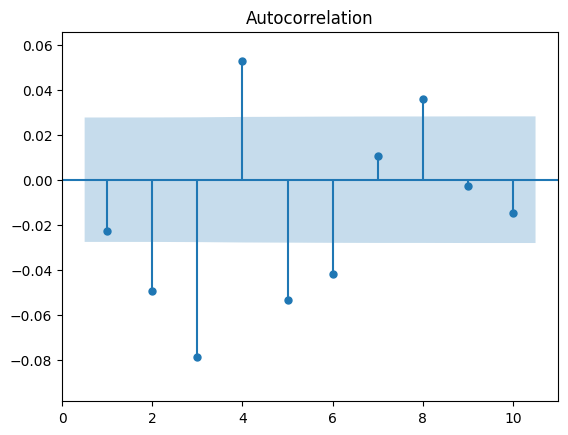

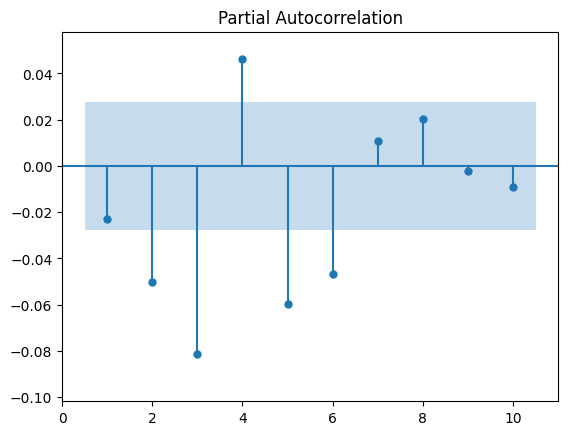

In [70]:
sgt.plot_acf(df['ret_norm'],auto_ylims=True,zero=False,lags=10)
sgt.plot_pacf(df['ret_norm'],auto_ylims=True,zero=False,lags=10)
plt.show()

### AR Model on Normalize data

In [71]:
model_ret_norm_ar_1=ARIMA(df['ret_norm'],order=(1,0,0))
result_ret_norm_ar_1=model_ret_norm_ar_1.fit()
result_ret_norm_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_norm   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood                6768.229
Date:                Thu, 01 Feb 2024   AIC                         -13530.458
Time:                        11:31:21   BIC                         -13510.895
Sample:                    01-10-1994   HQIC                        -13523.603
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4745      0.001    540.369      0.000       0.473       0.476
ar.L1         -0.0230      0.009     -2.698      0.007      -0.040      -0.006
sigma2         0.0039   3.94e-05    100.105      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.68
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
model_ret_norm_ar_6=ARIMA(df['ret_norm'],order=(6,0,0))
result_ret_norm_ar_6=model_ret_norm_ar_6.fit()
result_ret_norm_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_norm   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood                6811.033
Date:                Thu, 01 Feb 2024   AIC                         -13606.066
Time:                        11:31:23   BIC                         -13553.896
Sample:                    01-10-1994   HQIC                        -13587.785
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4745      0.001    620.788      0.000       0.473       0.476
ar.L1         -0.0247      0.009     -2.663      0.008      -0.043      -0.007
ar.L2         -0.0522      0.008     -6.495      0.000      -0.068      -0.036
ar.L3         -0.0869      0.008    -10.843      0.000      -0.103      -0.071
ar.L4          0.0425      0.008      5.144      0.000       0.026       0.059
ar.L5         -0.0607      0.008     -7.571      0.000      -0.076      -0.045
ar.L6         -0.0466      0.009     -5.221      0.000      -0.064      -0.029
sigma2         0.0039   4.19e-05     92.526      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6486.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Same Test stats as they were without Data normalization

AR(6) Peforming best to predict Future Returns

# Moving Average

## For returns

### ACF

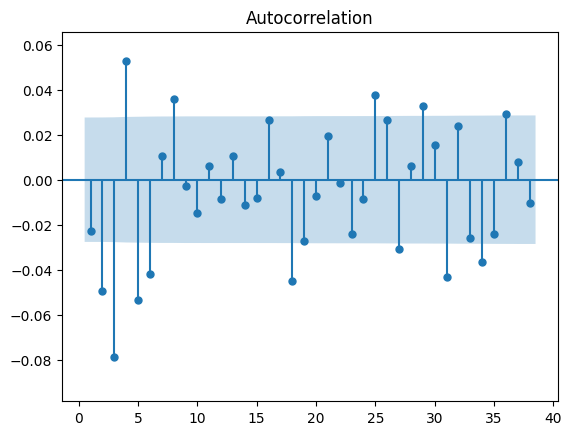

In [73]:
sgt.plot_acf(df['return'],auto_ylims=True,zero=False)
plt.show()

### MA(1)

In [74]:
df.rename({'return':'returns'},inplace=True,axis=1)

In [75]:
ma_ret_1=ARIMA(df.returns,order=(0,0,1))
result_ma_ret_1=ma_ret_1.fit()
result_ma_ret_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Thu, 01 Feb 2024   AIC                          15865.190
Time:                        11:31:25   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
ma_ret_2=ARIMA(order=(0,0,2),endog=df['returns'])
result_ma_ret_2=ma_ret_2.fit()
result_ma_ret_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Thu, 01 Feb 2024   AIC                          15853.728
Time:                        11:31:26   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.000      -0.066      -0.035
sigma2         1.3753      0.014     99.021      0.000       1.348       1.402
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              7657.23
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
ma_ret_6=ARIMA(order=(0,0,6),endog=df['returns'])
result_ma_ret_6=ma_ret_6.fit()
result_ma_ret_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Thu, 01 Feb 2024   AIC                          15794.442
Time:                        11:31:28   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.000      -0.064      -0.033
ma.L3         -0.0827      0.008    -10.179      0.000      -0.099      -0.067
ma.L4          0.0466      0.009      5.386      0.000       0.030       0.064
ma.L5         -0.0484      0.008     -5.991      0.000      -0.064      -0.033
ma.L6         -0.0387      0.009     -4.318      0.000      -0.056      -0.021
sigma2         1.3569      0.015     92.179      0.000       1.328       1.386
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6533.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
lr_test(ma_ret_6,ma_ret_2)

0.0

### Residual for Returns

In [79]:
px.line(df,y=result_ma_ret_6.resid)

#### residual are gaussain or not

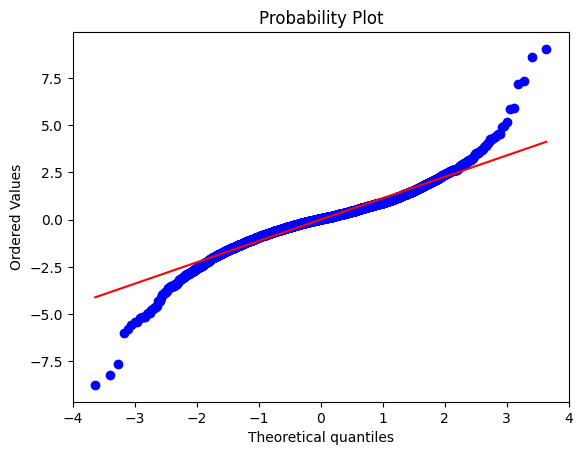

In [80]:
from scipy.stats import probplot
probplot(result_ma_ret_6.resid,plot=plt)
plt.show()

In [81]:
px.histogram(df,x=result_ma_ret_6.resid,marginal='rug')

#### Residual with less long tails

In [82]:
mean=result_ma_ret_6.resid.mean().round(3)
var=result_ma_ret_6.resid.var()
print(mean,var,sep='\n')

-0.0
1.3572114400803776


In [83]:
start=mean-3*var
end=mean+3*var

In [84]:
resid_df=df.copy()
resid_df['resid']=result_ma_ret_6.resid


In [85]:
resid_df[resid_df['resid'].between(start,end)]['resid']

date
1994-01-10   -0.175617
1994-01-11   -0.802080
1994-01-12   -1.268794
1994-01-13   -0.461334
1994-01-14    1.066725
                ...   
2013-04-01   -0.047742
2013-04-02    1.241705
2013-04-03   -1.091819
2013-04-04   -1.167812
2013-04-05   -1.471088
Name: resid, Length: 4978, dtype: float64

((array([-3.63455133, -3.39916279, -3.26942499, ...,  3.26942499,
          3.39916279,  3.63455133]),
  array([-4.00051868, -3.9850759 , -3.9604206 , ...,  3.91738929,
          3.98261769,  4.05216555])),
 (1.0426106540319378, 0.00799322284795276, 0.9904888500053296))

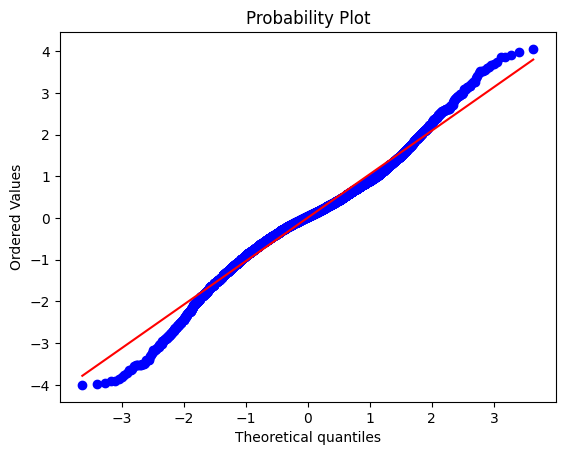

In [86]:
probplot(resid_df[resid_df['resid'].between(start,end)]['resid'],plot=plt)

In [87]:
px.histogram(x=resid_df[resid_df['resid'].between(start,end)]['resid'])

Finding:
    Very close to normal

### ACF for residual

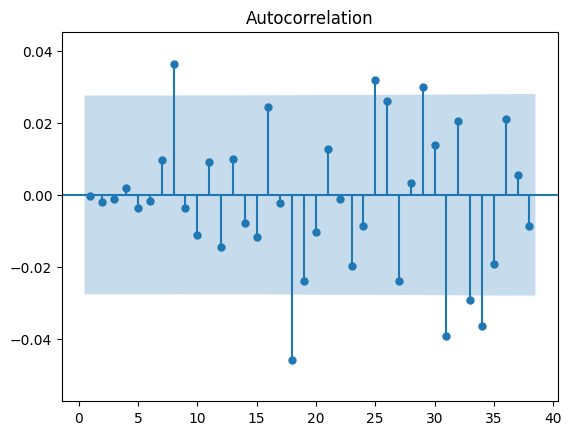

In [88]:
sgt.plot_acf(resid_df['resid'],zero=False,auto_ylims=True)
plt.show()

## For FTSE

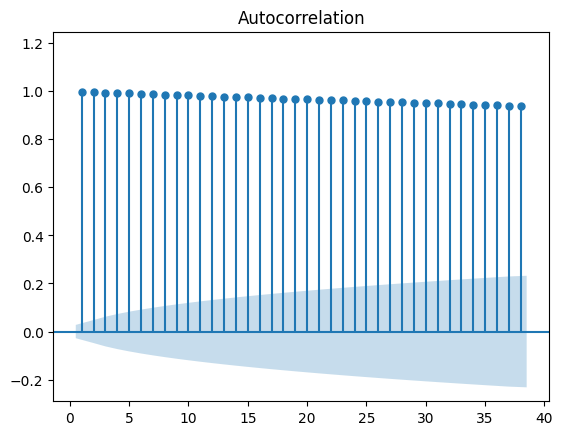

In [89]:
sgt.plot_acf(df['ftse'],zero=False,auto_ylims=True)
plt.show()

In [90]:
ma_1=ARIMA(endog=df['ftse'],order=(0,0,1))
result_ma_1=ma_1.fit()
result_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38620.627
Date:                Thu, 01 Feb 2024   AIC                          77247.253
Time:                        11:31:36   BIC                          77266.817
Sample:                    01-10-1994   HQIC                         77254.109
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.9580     15.768    322.812      0.000    5059.054    5120.862
ma.L1          0.9573      0.004    232.391      0.000       0.949       0.965
sigma2      2.804e+05   8087.127     34.675      0.000    2.65e+05    2.96e+05
===================================================================================
Ljung-Box (L1) (Q):                4219.89   Jarque-Bera (JB):               291.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coef of 0.95(very close) tell us that you will large number of errors(infinite) to get the model, which is not possible so MA not able to explain the non-stationary data

# ARMA Model

1. Start with ARMA(1,1)
2. Random Chose higher lag ARMA model and compare them using LR_test
3. From the best using ACF of residual get which lag has left over information, if you got 5 which is either 5 AR or 5 MA so Try every ARMA(5,Q) and ARMA(P,5), get best out of it using 

In [91]:
model_ret_ar_1_ma_5 = ARIMA(df.returns[1:], order=(1,0,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7889.868
Date:                Thu, 01 Feb 2024   AIC                          15795.735
Time:                        11:31:38   BIC                          15847.903
Sample:                    01-11-1994   HQIC                         15814.016
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.301      0.193      -0.010       0.048
ar.L1          0.3217      0.133      2.412      0.016       0.060       0.583
ma.L1         -0.3467      0.134     -2.591      0.010      -0.609      -0.084
ma.L2         -0.0406      0.010     -4.160      0.000      -0.060      -0.021
ma.L3         -0.0682      0.011     -6.095      0.000      -0.090      -0.046
ma.L4          0.0737      0.015      5.013      0.000       0.045       0.103
ma.L5         -0.0682      0.009     -7.403      0.000      -0.086      -0.050
sigma2         1.3581      0.015     91.582      0.000       1.329       1.387
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6460.20
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
r=sgt.acf(results_ret_ar_1_ma_5.resid,alpha=0.05)

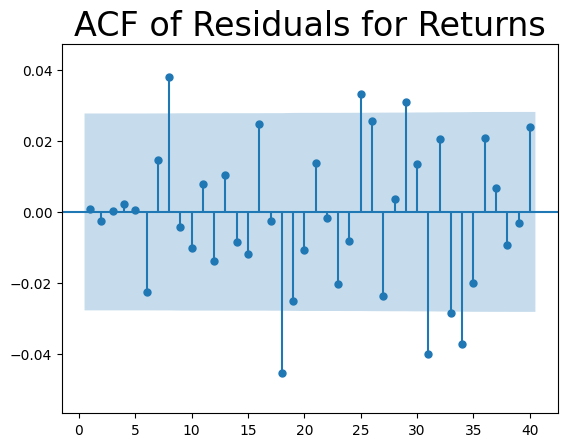

In [93]:
sgt.plot_acf(results_ret_ar_1_ma_5.resid, zero = False, lags = 40,auto_ylims=True)
plt.title("ACF of Residuals for Returns",size=24)
plt.show()

# SARIMAX

In [94]:
px.line(df,y='ftse')

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Looking the Seaonality at every 5th 
because of low memory for 13140 Days(3\*12\*3) since every 3 years seasonality can be seen

In [96]:
s=SARIMAX(df['ftse'],order=(1,1,1),seasonal_order=(2,0,1,5),exog=df['returns'])
s.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ftse   No. Observations:                 5020
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 5)   Log Likelihood              -25011.171
Date:                           Thu, 01 Feb 2024   AIC                          50036.342
Time:                                   11:31:52   BIC                          50081.989
Sample:                               01-10-1994   HQIC                         50052.338
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
returns       24.4505      0.095    258.646      0.000      24.265      24.636
ar.L1         -0.0063      0.015     -0.424      0.672      -0.035       0.023
ma.L1          0.6643      0.012     56.349      0.000       0.641       0.687
ar.S.L5       -0.0900      1.414     -0.064      0.949      -2.862       2.682
ar.S.L10      -0.0090      0.051     -0.176      0.861      -0.109       0.091
ma.S.L5        0.0538      1.413      0.038      0.970      -2.717       2.824
sigma2      1247.0664     14.953     83.400      0.000    1217.759    1276.373
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3235.50
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARCH

In [99]:
px.line(df,y='returns')

In [101]:
from arch import arch_model
m_arch=arch_model(df['returns'],mean='Constant',vol='ARCH',p=1,q=1,dist='normal')
m_arch.fit().summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 29071.83486537579
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12040.736044828116
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7809.7227529035545
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7660.088789376123
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7660.088782040906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Thu, Feb 01 2024   Df Residuals:                     5019
Time:                        11:50:51   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

In [102]:
from arch import arch_model
m_arch=arch_model(df['returns'],mean='Constant',lags=[5,6,8],vol='GARCH',p=1,q=1,dist='normal')
m_arch.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6579303469.390623
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2701100877.2298183
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7009.030632045198
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.035835212278
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712887007633
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.418108744094
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7092.271338807877
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879266228052
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6970.088048943886
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6970.0583674757745
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189882
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6970.058366189167
Optimization terminated successfully    (Exit mode 0)
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Thu, Feb 01 2024   Df Residuals:                     5019
Time:                        12:11:20   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## Auto ARIMA

In [103]:
from pmdarima import auto_arima

In [104]:
# m_autoarima=auto_arima(y=df['returns'])
# m_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5020
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -7883.710
Date:                Thu, 01 Feb 2024   AIC                          15787.420
Time:                        12:40:18   BIC                          15852.632
Sample:                    01-10-1994   HQIC                         15810.271
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0069      0.082      0.084      0.933      -0.154       0.168
ar.L2         -0.6553      0.078     -8.427      0.000      -0.808      -0.503
ar.L3         -0.1706      0.071     -2.388      0.017      -0.311      -0.031
ar.L4          0.1956      0.075      2.612      0.009       0.049       0.342
ma.L1         -0.0313      0.082     -0.384      0.701      -0.191       0.128
ma.L2          0.6082      0.078      7.755      0.000       0.455       0.762
ma.L3          0.0709      0.069      1.030      0.303      -0.064       0.206
ma.L4         -0.1877      0.074     -2.551      0.011      -0.332      -0.043
ma.L5         -0.1047      0.009    -11.040      0.000      -0.123      -0.086
sigma2         1.3519      0.015     91.638      0.000       1.323       1.381
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6372.25
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""